## Song Recommender Prototype
The dataset contains
- 1,019,318 unique users
- 384,546 unique MSD songs
- 48,373,586 user-song-playcount triplets

Issues: Too much data. 1) Noise introduced by low-playcount records 2) Taking too long to train models

Data Processing: Filter by playcount. Filter by users with too few ratings. Train and test split by userID (stratify).

Basic Model: BPR and IBPR.

## 0. Front-End UI

In [ ]:
!pip install --quiet ipywidgets

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [ ]:
import ipywidgets as widgets
from IPython.display import display, HTML, Audio

In [ ]:
SONG_FILE = "gdrive/My Drive/Data/Finesse.mp3"

In [ ]:
def play_audio():
  Audio(SONG_FILE)

In [ ]:
btn_new = widgets.Button(description='New User')
btn_existing = widgets.Button(description='Existing User')
text_userID = widgets.Text(placeholder='Enter your userID', description='User ID',disabled=False)
slider = widgets.IntSlider()

def btn_new_event_handler(obj):
  print("You have signed in as a New User => Help us know your preferences.")
  Audio(SONG_FILE)
  display(slider)

def btn_existing_event_handler(obj):
  print("You have signed in as Existing User. => Enter your User ID")
  display(text_userID)

def text_callback(obj):
  print("You have entered an User ID: " + obj.value)
  print("Retrieving your profile......")
  
btn_new.on_click(btn_new_event_handler)
btn_existing.on_click(btn_existing_event_handler)
text_userID.on_submit(text_callback)

### Step 1: Select between a New User or an Existing User

In [ ]:
display(btn_new)
display(btn_existing)

Button(description='New User', style=ButtonStyle())

Button(description='Existing User', style=ButtonStyle())

You have signed in as a New User => Help us know your preferences.


IntSlider(value=0)

In [ ]:
Audio(SONG_FILE)

## 1. Setup

In [1]:
!pip install --quiet cornac==1.6.1

     |████████████████████████████████| 10.1MB 2.8MB/s 


In [2]:
!git clone https://github.com/srendle/libfm.git
!make all -C libfm

Cloning into 'libfm'...
remote: Enumerating objects: 233, done.
remote: Total 233 (delta 0), reused 0 (delta 0), pack-reused 233
Receiving objects: 100% (233/233), 129.46 KiB | 248.00 KiB/s, done.
Resolving deltas: 100% (112/112), done.
make: Entering directory '/content/libfm'
cd src/libfm; make all
make[1]: Entering directory '/content/libfm/src/libfm'
g++ -O3 -Wall -c libfm.cpp -o libfm.o
mkdir -p ../../bin/
g++ -O3 -Wall libfm.o -o ../../bin/libFM
g++ -O3 -Wall -c tools/transpose.cpp -o tools/transpose.o
mkdir -p ../../bin/
g++ -O3 tools/transpose.o -o ../../bin/transpose
g++ -O3 -Wall -c tools/convert.cpp -o tools/convert.o
mkdir -p ../../bin/
g++ -O3 tools/convert.o -o ../../bin/convert
make[1]: Leaving directory '/content/libfm/src/libfm'
make: Leaving directory '/content/libfm'


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [4]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

import cornac
from cornac.data import Reader
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.models import Recommender, IBPR, BPR, WMF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%tensorflow_version 1.x
import tensorflow as tf

print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

# data processing
MIN_PLAYCOUNT = 5
MAX_PLAYCOUNT = 150
MIN_SONG_PER_USER = 30
MIN_USER_PER_SONG = 50

TEST_RATIO = 0.33
SEED = 2020
VERBOSE = False
PLAY_COUNT_DATA_PATH = "gdrive/My Drive/Data/train_triplets.txt"
TRAIN_DATA_PATH = "gdrive/My Drive/Data/triplets_train.csv"
TEST_DATA_PATH = "gdrive/My Drive/Data/triplets_test.csv"
FILTERED_DATA_PATH = "gdrive/My Drive/Data/filtered_triplets.csv"
TRACK_METADATA_PATH = "gdrive/My Drive/Data/track_metadata.db"
ARTIST_TERM_PATH = "gdrive/My Drive/Data/artist_term.db"
LASTFM_TAGS_PATH = "gdrive/My Drive/Data/lastfm_tags.db"
LYRICS_PATH = "gdrive/My Drive/Data/lyrics.db"
MODEL_DIR="gdrive/My Drive/Models/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.
Cornac version: 1.6.1
Tensorflow version: 1.15.2


In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 2. Data Exploration

#### Load Raw Data

In [ ]:
data = pd.read_csv(PLAY_COUNT_DATA_PATH, sep="\t", names=["user_id", "song_id", "play_count"], header=None) 

In [ ]:
data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


#### Data Sparsity

In [ ]:
def display_sparsity(data):
    n_users = data.user_id.nunique()
    n_songs = data.song_id.nunique()
    n_playcounts = len(data)
    playcount_matrix_size = n_users * n_songs
    sparsity = 1 - n_playcounts / playcount_matrix_size

    print(f"Number of unique users: {n_users}")
    print(f"Number of unique songs: {n_songs}")
    print(f"Number of available playcounts: {n_playcounts}")
    print(f"Number of all possible playcounts: {playcount_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.5f}%")

In [ ]:
display_sparsity(data)

Number of unique users: 1019318
Number of unique songs: 384546
Number of available playcounts: 48373586
Number of all possible playcounts: 391974659628
----------------------------------------
SPARSITY: 99.98766%


#### Top 10 songs by number of users who have played it

In [ ]:
song_play_num_users = data.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users.head(10)

song_id
SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
SONYKOW12AB01849C9     78353
SOEGIYH12A6D4FC0E3     69487
SOLFXKT12AB017E3E0     64229
SODJWHY12A8C142CCE     63809
SOFLJQZ12A6D4FADA6     58610
Name: user_id, dtype: int64

#### Bottom 10 songs by number of users who have played it

In [ ]:
song_play_num_users.tail(10)

song_id
SONJAWX12A8C13E25B    1
SOKRIGC12A8C1372F1    1
SOPKNIR12A8C138662    1
SORKHCW12A8C13D894    1
SOKRHUB12AB017E7FA    1
SOHEVJV12AC468C3FF    1
SOZCCGY12A8C12FF83    1
SOEPLCT12AB018AF1D    1
SOHEVIS12AB0186DF6    1
SORLFZJ12A8C13341C    1
Name: user_id, dtype: int64

#### Top 10 users with most number of songs

In [ ]:
user_num_songs = data.groupby("user_id")["song_id"].nunique().sort_values(ascending=False)
user_num_songs.head(10)

user_id
ec6dfcf19485cb011e0b22637075037aae34cf26    4400
8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc    1651
fef771ab021c200187a419f5e55311390f850a50    1614
5a3417a1955d9136413e0d293cd36497f5e00238    1604
c1255748c06ee3f6440c51c439446886c7807095    1566
4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f    1544
cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6    1536
96f7b4f800cafef33eae71a6bc44f7139f63cd7a    1491
119b7c88d58d0c6eb051365c103da5caf817bea6    1451
b7c24f770be6b802805ac0e2106624a517643c17    1446
Name: song_id, dtype: int64

#### Bottom 10 users with least number of songs
A user has at least listened to 10 songs.

In [ ]:
user_num_songs.tail(10)

user_id
2fd4c99cdc1232e9012299c6e41cb4a9f109a6a9    10
6b6ad4921f7510f48199c44c3f25e9045942373f    10
c531dc896216b11865071bd5f07d408e678c24da    10
c531c61652640db5e3d51c670c1df9cdb659698d    10
c52fedd2d9b96ccf22d3ff8775a82ccb62ad4fbe    10
c52fd9d20260585850f260fed445b633df9b3b71    10
1d477e518edfb3ebc6e56951e55570af25daffe3    10
6b6e2a832c28b6e09ac1b02f277c6cd821418020    10
2fd3dba782fe0b3ba2248e3b1153cdae97dcebc5    10
a546a96e6e0f12423bc27c01b2f43446ff0ca012    10
Name: song_id, dtype: int64

#### Data Statistics

In [ ]:
data.describe()

,play_count
count,48373586.000
mean,2.867
std,6.438
min,1.000
25%,1.000
50%,1.000
75%,3.000
max,9667.000


#### Power Law Distribution

In [ ]:
sample_size = 5000
seed = 2020
sample_df = song_play_num_users.sample(n=sample_size, random_state=seed)
sample_df = sample_df.sort_values(ascending=False)

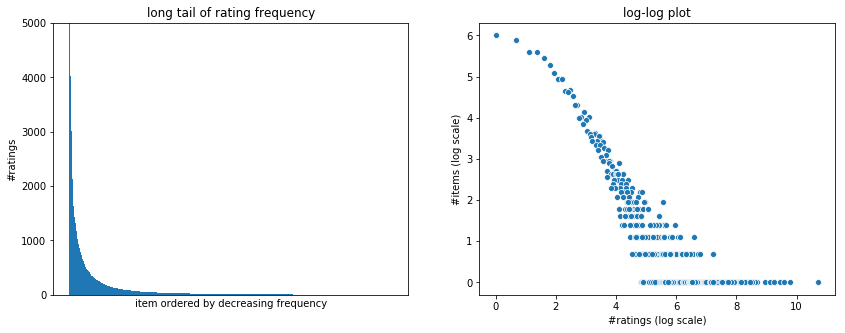

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")
axes[0].set_ylim([0, 5000])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## 3. Data Processing

#### Filter ratings by play count
Users might accidentally play a song. By removing ratings with less than 5 play counts, we try to remove this noise.

In [ ]:
filtered_df = data[(data['play_count'] >= MIN_PLAYCOUNT) & (data['play_count'] <= MAX_PLAYCOUNT)]

In [ ]:
display_sparsity(filtered_df)

Number of unique users: 766847
Number of unique songs: 260390
Number of available playcounts: 7254811
Number of all possible playcounts: 199679290330
----------------------------------------
SPARSITY: 99.99637%


#### Filter songs with number of users
It's hard to infer the general likeability of a song if there are too few ratings.

In [ ]:
# filtered_df = filtered_df.groupby(['song_id']).filter(lambda x: x['user_id'].nunique() >= MIN_USER_PER_SONG)

In [ ]:
# display_sparsity(filtered_df)

#### Filter users with number of songs
We will not consider the cold-start problem at this stage, therefore we remove users with insufficent number of ratings.

In [ ]:
filtered_df = filtered_df.groupby(['user_id']).filter(lambda x: x["song_id"].nunique() >= MIN_SONG_PER_USER)

In [ ]:
display_sparsity(filtered_df)

Number of unique users: 41943
Number of unique songs: 179199
Number of available playcounts: 1922463
Number of all possible playcounts: 7516143657
----------------------------------------
SPARSITY: 99.97442%


In [ ]:
user_num_songs = filtered_df.groupby("user_id")["song_id"].nunique().sort_values(ascending=False)
user_num_songs.tail(5)

user_id
358b6b35c6a04dfb1c5bbef630a9d57823ba4689    30
358d12bc13c49646b39390b618e54403d505acdb    30
b37d2daa45217cdb49c8049396617536ff3771a4    30
15a5953926b0d30da0887f8c10c99525b887f110    30
9dca51444a8c290b9c5bae92d40cea247420b1f4    30
Name: song_id, dtype: int64

#### Save filtered data

In [ ]:
filtered_df.to_csv(FILTERED_DATA_PATH, sep='\t', header = None, index = False)

#### Load filtered data

In [ ]:
filtered_df = pd.read_csv(FILTERED_DATA_PATH, sep="\t", names=["user_id", "song_id", "play_count"], header=None) 

#### Train-Test Split

In [ ]:
X = filtered_df[["song_id", "play_count"]]
Y = filtered_df["user_id"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_RATIO, stratify=Y)

In [ ]:
train = pd.concat([Y_train, X_train], axis=1)
test = pd.concat([Y_test, X_test], axis=1)

In [ ]:
uid = "a14bff38e3725de8e4bd5a80c637b13f3ba54831"

In [ ]:
# Test stratified split
filtered_df.groupby(['user_id'])["song_id"].nunique()[uid]

40

In [ ]:
train.groupby(['user_id'])["song_id"].nunique()[uid]

27

In [ ]:
test.groupby(['user_id'])["song_id"].nunique()[uid]

13

#### Data Statistics

In [ ]:
display_sparsity(train)

Number of unique users: 41943
Number of unique songs: 153590
Number of available playcounts: 1288050
Number of all possible playcounts: 6442025370
----------------------------------------
SPARSITY: 99.98001%


In [ ]:
display_sparsity(test)

Number of unique users: 41943
Number of unique songs: 113185
Number of available playcounts: 634413
Number of all possible playcounts: 4747318455
----------------------------------------
SPARSITY: 99.98664%


#### Save to CSV files

In [ ]:
train.to_csv(TRAIN_DATA_PATH, sep='\t', index = False)
test.to_csv(TEST_DATA_PATH, sep='\t', index = False)

## 4. Base Model

#### Read CSV files

In [ ]:
reader = Reader()
train_data = reader.read(TRAIN_DATA_PATH, sep="\t", skip_lines=1)
test_data = reader.read(TEST_DATA_PATH, sep="\t", skip_lines=1)

#### Define Evaluation Metrics and Method

In [ ]:
eval_metrics = [
  cornac.metrics.RMSE(), 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=10),
  cornac.metrics.Recall(k=10),
  cornac.metrics.FMeasure(k=10),
  cornac.metrics.NDCG(k=[10, 20, 30]),
  cornac.metrics.MRR(),
  cornac.metrics.MAP()
]

In [ ]:
base_method = BaseMethod.from_splits(train_data, test_data, exclude_unknowns=True, seed=SEED, verbose=True)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 41943
Number of items = 153590
Number of ratings = 1288050
Max rating = 150.0
Min rating = 5.0
Global mean = 11.0
---
Test data:
Number of users = 41943
Number of items = 87576
Number of ratings = 603916
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 41943
Total items = 153590


#### Train Base Models

In [ ]:
K=20

In [ ]:
bpr = BPR(k=K, max_iter=50, learning_rate=0.01, lambda_reg=0.001, verbose=True, seed=SEED, name=f"song_BPR(K={K})")
ibpr = IBPR(k=K, max_iter=5, learning_rate=0.05, lamda=0.001, batch_size=100, verbose=True, name=f"song_IBPR(K={K})"  )

In [ ]:
cornac.Experiment(eval_method=base_method, models=[ibpr], metrics=eval_metrics, save_dir=MODEL_DIR).run()


[song_IBPR(K=10)] Training started!




[song_IBPR(K=10)] Evaluation started!



song_IBPR(K=10) model is saved to gdrive/My Drive/Models/song_IBPR(K=10)/2020-07-20_12-02-11-701281.pkl

TEST:
...
                |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) |  Test (s)
--------------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + ---------
song_IBPR(K=10) | 9.4016 | 0.8396 | 0.0009 | 0.0015 | 0.0074 |  0.0011 |  0.0014 |  0.0018 |       0.0011 |    0.0008 | 3672.6555 | 4207.5755



In [ ]:
cornac.Experiment(eval_method=base_method, models=[bpr], metrics=eval_metrics, save_dir=MODEL_DIR).run()


[song_BPR(K=20)] Training started!



Optimization finished!

[song_BPR(K=20)] Evaluation started!



song_BPR(K=20) model is saved to gdrive/My Drive/Models/song_BPR(K=20)/2020-07-20_13-09-37-109450.pkl

TEST:
...
               |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | NDCG@20 | NDCG@30 | Precision@10 | Recall@10 | Train (s) |  Test (s)
-------------- + ------ + ------ + ------ + ------ + ------ + ------- + ------- + ------- + ------------ + --------- + --------- + ---------
song_BPR(K=20) | 9.3958 | 0.8780 | 0.0218 | 0.0159 | 0.0822 |  0.0278 |  0.0304 |  0.0347 |       0.0266 |    0.0192 |   42.0458 | 3157.8491



#### Load Pre-trained Model

In [ ]:
PRETRAINED_MODEL_PATH = "gdrive/My Drive/Models/song_BPR(K=20).pkl"
bpr = Recommender.load(PRETRAINED_MODEL_PATH)

In [ ]:
result = base_method.evaluate(bpr, eval_metrics, user_based=True)
for each in result:
  print(each)

#### BPR Latent Factors

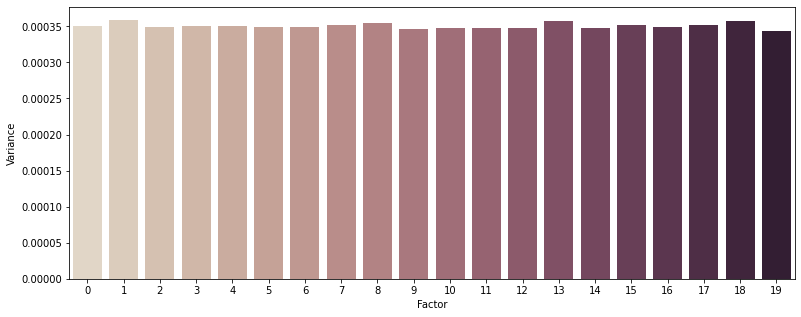

In [ ]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(bpr.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
sns.barplot(x="Factor", y="Variance", data=var_df, palette="ch:.25", ax=ax);

## 5. User Segmentation using Artists

#### Load filtered data

In [ ]:
filtered_df = pd.read_csv(FILTERED_DATA_PATH, sep="\t", names=["user_id", "song_id", "play_count"], header=None) 

#### Get Song Metadata

In [ ]:
conn = sqlite3.connect(TRACK_METADATA_PATH)
conn.commit()
c = conn.cursor()
c.execute('SELECT * FROM songs')
metadata = pd.DataFrame(
    c.fetchall(), 
    columns=['track_id','title','song_id','release','artist_id','artist_mbid','artist_name',
             'duration','artist_familiarity','artist_hottness','year','track_7digitalid','shs_perf','shs_work']
)

In [ ]:
metadata.head(5)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hottness,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.06,0.65,0.39,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55,0.44,0.36,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97,0.64,0.44,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.06,0.45,0.37,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.30,0.00,0.00,0,2264873,-1,0


Since we only can link the metadata and triplet by song_id but link other dataset by track_id. I only keep one trick_id for one song.

In [ ]:
metadata_uniquesong = metadata.drop_duplicates(subset='song_id', keep="first")

In [ ]:
merged = pd.merge(filtered_df, metadata_uniquesong, on='song_id', how='left')
merged.head(5)

,user_id,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hottness,year,track_7digitalid,shs_perf,shs_work
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,TRWYBFS128E078DA29,You And Me Jesus,Tribute To Jake Hess,ARDFZE61187FB45994,d8881a78-e6c6-4cd7-bd43-1a6c4b8ef4ba,Jake Hess,199.26,0.37,0.33,2004,142275,-1,0
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,TRCPAGR128F423A01A,Lucky (Album Version),We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,82eb8936-7bf6-4577-8320-a2639465206d,Jason Mraz & Colbie Caillat,189.62,0.84,0.77,0,2638597,-1,0
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBONKR12A58A7A7E0,26,TRAEHHJ12903CF492F,You're The One,If There Was A Way,AR5E44Z1187B9A1D74,0fb711af-c7ba-4bdc-b0b6-b8495fc0a590,Dwight Yoakam,239.31,0.78,0.51,1990,6686507,-1,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBZZDU12A6310D8A3,7,TRGWWRE128E0781CDE,Don't Dream It's Over,Recurring Dream_ Best Of Crowded House (Domest...,ARKGS2Z1187FB494B5,9854d99f-d954-4c0f-9ae5-58a0cdd885f5,Crowded House,235.55,0.72,0.58,1986,7716,8638,8638
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOCAHRT12A8C13A1A4,5,TRWKUFF128F4255667,S.O.S.,SOS,ARWQ4AM1187B9AD5F8,6e019bc6-5c23-4935-94f0-4a896631d846,Jonas Brothers,153.47,0.88,0.63,2007,2759159,-1,0


#### Get Tags

In [ ]:
conn = sqlite3.connect(ARTIST_TERM_PATH)
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table_name in tables.name.tolist():
    print(table_name)

artists
terms
artist_term
mbtags
artist_mbtag


In [ ]:
c = conn.cursor()
c.execute('SELECT * FROM artist_mbtag')
tags = pd.DataFrame(
    c.fetchall(), 
    columns=['artist_id','mbtag']
)

In [ ]:
tags.head(5)

,artist_id,mbtag
0,AR002UA1187B9A637D,uk
1,AR002UA1187B9A637D,rock
2,AR002UA1187B9A637D,garage rock
3,AR006821187FB5192B,bass
4,AR00A6H1187FB5402A,detroit


In [ ]:
merged_tags = pd.merge(merged, tags, on='artist_id', how='left')
merged_tags.head(5)

,user_id,song_id,play_count,track_id,title,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hottness,year,track_7digitalid,shs_perf,shs_work,mbtag
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,TRWYBFS128E078DA29,You And Me Jesus,Tribute To Jake Hess,ARDFZE61187FB45994,d8881a78-e6c6-4cd7-bd43-1a6c4b8ef4ba,Jake Hess,199.26,0.37,0.33,2004,142275,-1,0,NaN
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,TRCPAGR128F423A01A,Lucky (Album Version),We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,82eb8936-7bf6-4577-8320-a2639465206d,Jason Mraz & Colbie Caillat,189.62,0.84,0.77,0,2638597,-1,0,pop rock
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,TRCPAGR128F423A01A,Lucky (Album Version),We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,82eb8936-7bf6-4577-8320-a2639465206d,Jason Mraz & Colbie Caillat,189.62,0.84,0.77,0,2638597,-1,0,alternative rock
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,TRCPAGR128F423A01A,Lucky (Album Version),We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,82eb8936-7bf6-4577-8320-a2639465206d,Jason Mraz & Colbie Caillat,189.62,0.84,0.77,0,2638597,-1,0,rock
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,TRCPAGR128F423A01A,Lucky (Album Version),We Sing. We Dance. We Steal Things.,ARML3X41187FB35F2E,82eb8936-7bf6-4577-8320-a2639465206d,Jason Mraz & Colbie Caillat,189.62,0.84,0.77,0,2638597,-1,0,american


#### Top 10 Artist for any user

In [ ]:
uid="d6589314c0a9bcbca4fee0c93b14bc402363afea"
merged_tags.groupby(["user_id", "artist_id"]).play_count.nlargest(2)

user_id                                   artist_id                  
00020e8ba3f9041deed64ec9c60b26ff6bf41c66  AR6FJXP1187B997DED  2295250     7
                                          AR7HBPN1187B98FC29  2295332     5
                                          ARAOQ5T1187FB435AB  2295194     5
                                                              2295195     5
                                          ARD46C811C8A414F3F  2295283     6
                                                                         ..
ffff6f29052de81f5720b1ccf4ee41457d0fd5e8  ARX94AN1187FB4B54B  2334610    12
                                                              2334545     7
                                          ARZBH9G1187B99B918  2334527    10
                                          ARZWK2R1187B98F09F  2334563    14
                                                              2334564    14
Name: play_count, Length: 1944146, dtype: int64

In [ ]:
df_top10 = merged_tags.loc[merged_tags['artist_id'].isin(top10.reset_index()['artist_id'])]

KeyError: ignored

In [ ]:
top10

user_id                                          
00020e8ba3f9041deed64ec9c60b26ff6bf41c66  2295252    42
                                          2295304    20
                                          2295305    20
                                          2295224    16
                                          2295225    16
                                                     ..
ffff6f29052de81f5720b1ccf4ee41457d0fd5e8  2334543    16
                                          2334544    16
                                          2334508    15
                                          2334509    15
                                          2334510    15
Name: play_count, Length: 419430, dtype: int64

#### Cosine Similarity between Users

#### Clustering